In [208]:
pip install spark

In [209]:
!pip install pyspark

## Kütüphanelerin Eklenmesi

In [210]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.sql.functions import approx_percentile

from pyspark.ml import *
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression

import scipy.stats as stats
from scipy.stats import shapiro

## Spark Ortamının Oluşturulması

In [211]:
spark = SparkSession.builder.appName("spark-project").getOrCreate()

## Verilerin Yüklenmesi

In [212]:
csv = spark.read.csv("/content/housing.csv", inferSchema=True, header=True)
csv.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

## Veriyi Hazırlama Aşaması

In [213]:
csv.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string')]

- StringIndexer: ocean_proximity sütununu sayısal değerlere dönüştürür


In [214]:
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")

# Veri üzerinde StringIndexer uygulama
indexed_data = indexer.fit(csv).transform(csv)
data = indexed_data.drop("ocean_proximity")

In [215]:
data.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_indexed|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|                    3.0|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|                    3.0|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|                    3.0|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|   

- veri hakkında bilgi edinmek icin describe metodunu kullanıyoruz.


In [216]:
data.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity_indexed|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|                  20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|     

- Herhangi bir sütun için boş değer sayısına ulaşmak için aşağıdaki yöntemi kullanıyoruz.


In [217]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_indexed|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|                      0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+



- Nan değerleri -aykırı degerlerden etkilenmemesi için- medyan ile doldurma işlemi


In [218]:
# total_bedrooms sütunundaki NaN değerleri medyan ile doldurma
median_value = data.approxQuantile("total_bedrooms", [0.5], 0.25)[0]
data = data.na.fill({'total_bedrooms': median_value})

- Herhangi bir sütun için boş değer sayısına ulaşmak için aşağıdaki yöntemi kullanıyoruz.

In [219]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_indexed|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|                      0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+



- verideki duplicate satırların kontrolünü distinct ile sağlarız. Bu yöntemle verimizle distinct uygulanmış veri arasındaki farkı gözlemleyebiliriz.

In [220]:
distinct_df = data.distinct()
print(f"Data row count: {data.count()}")
print(f"Distinct row count: {distinct_df.count()}")

if data.count() == distinct_df.count():
  print("Veride duplicate satır bulunmamaktadır.")
else:
  print(f"Veride {data.count()-distinct_df.count()} duplicate satır bulunmaktadır.")


Data row count: 20640
Distinct row count: 20640
Veride duplicate satır bulunmamaktadır.


- hedef değişkenimizin dağılımını gözlemlemek için histogram grafiği çizdiriyoruz. Bu şekilde veri hakkında bilgi sahibi olabiliriz.


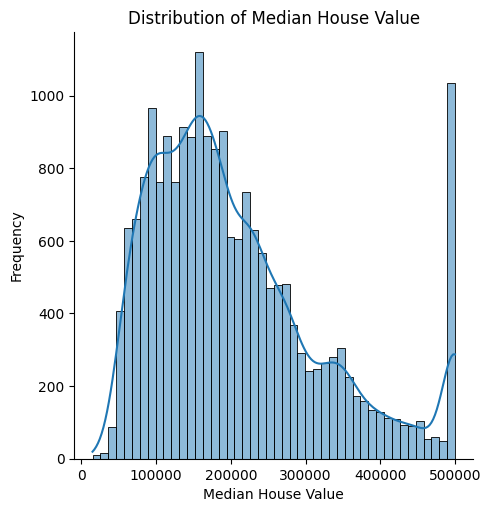

In [221]:
# median_house_value sütununun histogramını çizelim
median_house_value_data = data.select("median_house_value").toPandas()

# Histogram
sns.displot(median_house_value_data["median_house_value"], kde=True)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()



- Histogram grafiğinin simetrik olmadığını gözlemliyoruz. Bu durum verimizin normal dağılıma sahip olmadığının bir işareti olabilir.Bu durumu daha detaylı incelemek için başka yöntemlere başvurmalıyız.

----------------------------------------------------

- Verimizin normal dağılım durumunu kontrol etmek için qq plot kullanıyoruz. Verilerimiz merkez hatta ne kadar yakınsa verilerin yayılımı normal dağılıma o kadar yakındır diyebiliriz.

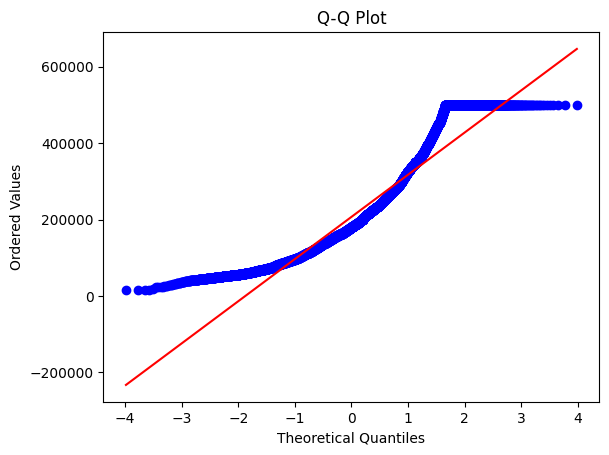

In [222]:
# Q-Q plot çizimi
stats.probplot(median_house_value_data["median_house_value"], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()


- Plot incelendiğinde verimizin normal dağılıma sahip olmadığını söyleyebiliriz.
--------------------------------------------------
- Son olarak Shapiro-Wilk testi yaparak verimize normallik testi yapıyoruz.


In [223]:
# Shapiro-Wilk testi
stat, p = shapiro(median_house_value_data["median_house_value"])
print('Statistics=%.3f, p=%.3f' % (stat, p))


alpha = 0.05
if p > alpha:
    print('Örnek normal dağılıma sahiptir (H0 reddedilemez)')
else:
    print('Örnek normal dağılıma sahip değildir (H0 reddedilir)')

Statistics=0.912, p=0.000
Örnek normal dağılıma sahip değildir (H0 reddedilir)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Veri Görselleştirme Aşamaları

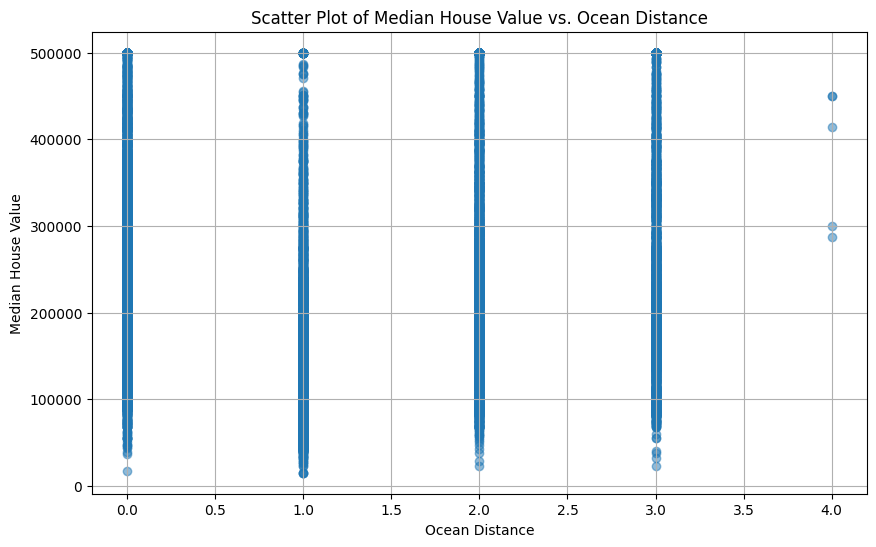

In [224]:
# Scatter plot çizimi
plt.figure(figsize=(10, 6))
plt.scatter(data.select("ocean_proximity_indexed").collect(), data.select("median_house_value").collect(), alpha=0.5)
plt.title('Scatter Plot of Median House Value vs. Ocean Distance')
plt.xlabel('Ocean Distance')
plt.ylabel('Median House Value')
plt.grid(True)
plt.show()

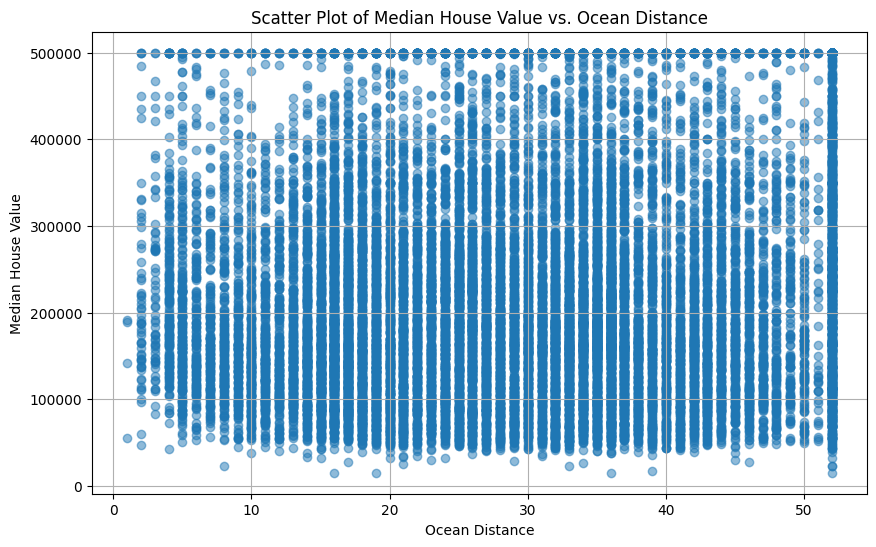

In [225]:
# Scatter plot çizimi
plt.figure(figsize=(10, 6))
plt.scatter(data.select("housing_median_age").collect(), data.select("median_house_value").collect(), alpha=0.5)
plt.title('Scatter Plot of Median House Value vs. Ocean Distance')
plt.xlabel('Ocean Distance')
plt.ylabel('Median House Value')
plt.grid(True)
plt.show()

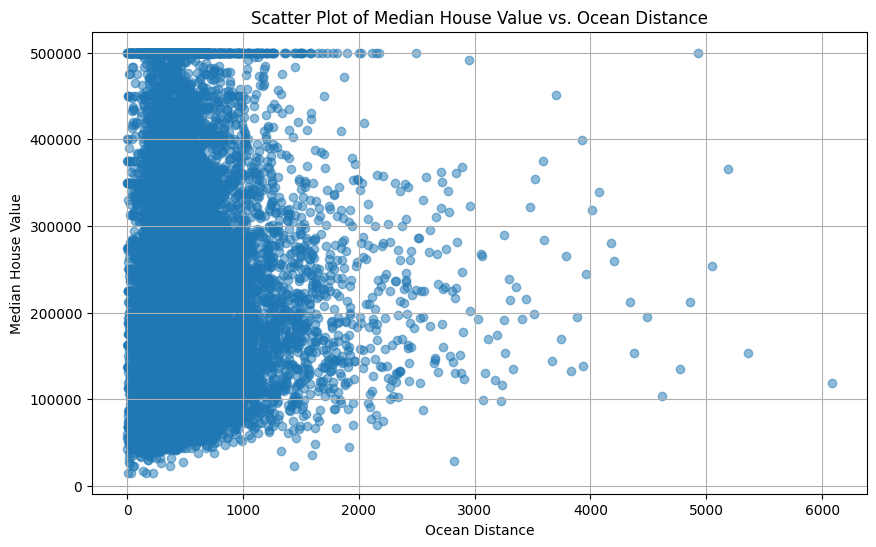

In [226]:
# Scatter plot çizimi
plt.figure(figsize=(10, 6))
plt.scatter(data.select("households").collect(), data.select("median_house_value").collect(), alpha=0.5)
plt.title('Scatter Plot of Median House Value vs. Ocean Distance')
plt.xlabel('Ocean Distance')
plt.ylabel('Median House Value')
plt.grid(True)
plt.show()

In [227]:
type(data)

pyspark.sql.dataframe.DataFrame

## Feature Selection

***Korelasyon Analizi***: İki değişken arasındaki ilişkinin gücünü ve yönünü belirlemek için kullanılan istatistiksel bir tekniktir. Genellikle Pearson korelasyon katsayısı kullanılarak yapılır.

Pearson korelasyon katsayısı, iki değişken arasındaki doğrusal ilişkiyi ölçer. Değerleri genellikle -1 ile +1 arasında değişir:

- +1: Mükemmel pozitif korelasyon, yani iki değişken arasında tam bir doğrusal ilişki vardır.
- 0: Herhangi bir korelasyon yok, yani değişkenler arasında herhangi bir doğrusal ilişki yoktur.
- -1: Mükemmel negatif korelasyon, yani iki değişken arasında tam ters yönlü bir doğrusal ilişki vardır.

In [228]:
# Korelasyon analizi için korelasyon tablosu oluşturuyoruz

# PySpark DataFrame'ini Pandas DataFrame'ine dönüştürme
pandas_df = data.toPandas()

# Özellikler arasındaki korelasyonu hesaplayalım
correlation_matrix = pandas_df.corr()

# Korelasyon tablosunu oluşturalım
# Her bir hücre, iki özellik arasındaki korelasyon katsayısını içerecek
correlation_table = correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

# Korelasyon tablosunu yazdıralım
correlation_table


<ipython-input-228-87d4e2774595>:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation_table = correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_indexed
longitude,1.00,-0.92,-0.11,0.04,0.07,0.10,0.06,-0.02,-0.05,-0.44
latitude,-0.92,1.00,0.01,-0.04,-0.07,-0.11,-0.07,-0.08,-0.14,0.39
housing_median_age,-0.11,0.01,1.00,-0.36,-0.32,-0.30,-0.30,-0.12,0.11,0.15
total_rooms,0.04,-0.04,-0.36,1.00,0.93,0.86,0.92,0.20,0.13,-0.02
total_bedrooms,0.07,-0.07,-0.32,0.93,1.00,0.87,0.97,-0.01,0.05,-0.02
population,0.10,-0.11,-0.30,0.86,0.87,1.00,0.91,0.00,-0.02,-0.08
households,0.06,-0.07,-0.30,0.92,0.97,0.91,1.00,0.01,0.07,-0.03
median_income,-0.02,-0.08,-0.12,0.20,-0.01,0.00,0.01,1.00,0.69,-0.04
median_house_value,-0.05,-0.14,0.11,0.13,0.05,-0.02,0.07,0.69,1.00,0.02
ocean_proximity_indexed,-0.44,0.39,0.15,-0.02,-0.02,-0.08,-0.03,-0.04,0.02,1.00


- Özelliklerin hedef değişkenimize göre korelasyonunu inceleyebilmek için bu korelasyon tablosunu özelleştiriyoruz.
-'median_house_value' değişkenine göre (hedef değişkenimiz) diğer değişkenlerin korelasyonunu filtreliyoruz.

In [229]:
median_house_value_corr = correlation_matrix['median_house_value'].sort_values(ascending=False)
median_house_value_corr

median_house_value         1.000000
median_income              0.688075
total_rooms                0.134153
housing_median_age         0.105623
households                 0.065843
total_bedrooms             0.049415
ocean_proximity_indexed    0.021732
population                -0.024650
longitude                 -0.045967
latitude                  -0.144160
Name: median_house_value, dtype: float64

- Verilerimize normalizasyon uygulayacağız. Bunun için de daha önce yapmış olduğumuz analizleri kullanacağız. Yaptığımız analizlere - grafikler - bakarak verimizin normal dağılıma sahip olmadığını keşfettik. Bu sebeple Normalizasyon yöntemi olarak Min-Max normalizasyonunu tercih edebilriz. Bu normalizasyon ile verilerimizi [0,1] aralığına çekiyor oluyoruz. Ayrıca aykırı değerler ile başa çıkmamıza da yardımcı olur.

------------------------------------------------------


- Random Forest Regresyon ile modeli eğitiyoruz ve modelin özellik önem sırasını listeliyoruz.

In [230]:
def feature_elimination_w_RF(data):
  # Özellik adlarını alalım
  selected_feature_names = data.drop('median_house_value').columns

  # Model eğitimi
  rf_model = RandomForestRegressor(featuresCol='features', labelCol='median_house_value')
  trained_model = rf_model.fit(data)

  # Özellik önem sıralamasını al
  feature_importances = trained_model.featureImportances.toArray()

  # Özellik önem sıralamasını yazdır
  sorted_indices = feature_importances.argsort()[::-1]
  sorted_features = [selected_feature_names[i] for i in sorted_indices]

  return sorted_features

- Normalizasyon uygulamamız için önce sütunları vektör haline getirmemiz gerek.(VectorAssembler ile)

In [231]:
def create_features_column(data):
  features = data.drop('median_house_value')

  assembler = VectorAssembler(inputCols = features.columns, outputCol="features")
  selected_features_df = assembler.transform(data)

  return selected_features_df

- Normalizasyon uyguluyoruz.

In [232]:
def scale_data(data):
  scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
  scaler_model = scaler.fit(data)
  scaled_data = scaler_model.transform(data)
  return scaled_data

- Verimizi train ve test olacak şekilde bölüyoruz. Daha sonrasında kullanmak için X_train ve y_train değişkenlerini oluşturuyoruz.

In [233]:
def train_test_split(data):
  train_df,test_df = data.randomSplit([0.7,0.3])

  X_train = train_df['scaled_features']
  y_train = train_df['median_house_value']

  return train_df, test_df, X_train, y_train

- Elastik net regresyonu kullanacağımız featurelar ile performans değerlendirmesi yaparak, seçeceğimiz featureları belirliyoruz.

In [234]:
def elastic_net_regression(train_df, test_df):
  # Elastik Net Regresyonu
  elastic_net = LinearRegression(featuresCol="scaled_features", labelCol="median_house_value", maxIter=100, elasticNetParam=0.5)
  elastic_net_model = elastic_net.fit(train_df)

  # Test verileri üzerinde tahminler yapma
  predictions = elastic_net_model.transform(test_df)

  # Performansı değerlendirme
  evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)
  print("RMSE(Root Mean Squared Error):", rmse)

- Tüm özelliklerle performans değerlendirmesi yaptım sonuç -> RMSE: 70706.41998330006
- median_house_value özelliği ile pozitif korelasyona sahip özelliklerle performans değerlendirmesi sonucu -> RMSE: 77611.00635175662
- 5 pozitif korelasyon değeri ile  -> RMSE: 76324.45554931594
- 4 pozitif korelasyon değeri ile  -> RMSE: 80258.89410375102
-----------------------------------------------------

- Feature elimination yöntemlerinden çok verim alamadığımız için bazı feature extraction yöntemlerine başvuracağız. Öncelikle özellik birleştirme ve daha sonrası mevcut özelliklerden türevsel özellikler elde edip daha güçlü özellikler oluşturabiliriz.

- Özellik Birleştirme: total_rooms ve total_bedrooms sütunlarını toplayarak yeni bir özellik oluşturma
- Türevsel Özellikler: population ve households özelliklerini kullanarak yeni bir özellik oluşturma


In [235]:
# asıl veri setimiz data idi
df = data.withColumn('total_rooms_bedrooms', col('total_rooms') + col('total_bedrooms'))

df = df.withColumn('population_density', col('population') / col('households'))

# Yeni özelliklerle güncellenmiş veri setini gösterilmesi
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+--------------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity_indexed|total_rooms_bedrooms|population_density|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+-----------------------+--------------------+------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|                    3.0|              1009.0|2.5555555555555554|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|                    3.0|              8205.0| 2.109841827768014|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|    

- Yeni özelliklerimiz -> total_rooms_bedrooms ve population_density
- Şimdi bu özelliklerle performans değerlendirmesi yapalım ve ardından feature elimination deneyelim.

In [236]:
df_w_features = create_features_column(df)
df_w_features.select('features').show(truncate=False)
normalized_data = scale_data(df_w_features)
normalized_data.show()

+------------------------------------------------------------------------------------+
|features                                                                            |
+------------------------------------------------------------------------------------+
|[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,3.0,1009.0,2.5555555555555554]   |
|[-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0,8205.0,2.109841827768014]|
|[-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0,1657.0,2.8022598870056497]  |
|[-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0,1509.0,2.547945205479452]   |
|[-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0,1907.0,2.1814671814671813]  |
|[-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,3.0,1132.0,2.139896373056995]    |
|[-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,3.0,3024.0,2.1284046692607004] |
|[-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,3.0,3791.0,1.7882534775888717]   |
|[-122.26,37.84,42.0,2555.0,665.0,1206.0,59

In [237]:
train_df,test_df, X_train, y_train = train_test_split(normalized_data)

In [238]:
elastic_net_regression(train_df, test_df)

RMSE(Root Mean Squared Error): 70519.8584170937


- İki yeni feature'dan sonra performansımız düştü. Önce -> 71049.04746728615 Sonra -> 71199.24250956689

In [239]:
features = feature_elimination_w_RF(normalized_data)
print("Özellik önem sıralaması:", features)

Özellik önem sıralaması: ['median_income', 'ocean_proximity_indexed', 'population_density', 'latitude', 'longitude', 'housing_median_age', 'total_rooms', 'population', 'households', 'total_rooms_bedrooms', 'total_bedrooms']


- Şimdi bu özelliklerin sırasına göre performans değerlendirme yapalım

In [240]:
# Özelliklerin belirlenmes
selected_features = ['median_income', 'ocean_proximity_indexed', 'population_density', 'latitude', 'longitude', 'housing_median_age', 'total_rooms', 'population','households', 'median_house_value']

# Belirtilen özellikleri içeren yeni bir veri
selected_features_data = df.select(*selected_features)

selected_features_data.show()

+-------------+-----------------------+------------------+--------+---------+------------------+-----------+----------+----------+------------------+
|median_income|ocean_proximity_indexed|population_density|latitude|longitude|housing_median_age|total_rooms|population|households|median_house_value|
+-------------+-----------------------+------------------+--------+---------+------------------+-----------+----------+----------+------------------+
|       8.3252|                    3.0|2.5555555555555554|   37.88|  -122.23|              41.0|      880.0|     322.0|     126.0|          452600.0|
|       8.3014|                    3.0| 2.109841827768014|   37.86|  -122.22|              21.0|     7099.0|    2401.0|    1138.0|          358500.0|
|       7.2574|                    3.0|2.8022598870056497|   37.85|  -122.24|              52.0|     1467.0|     496.0|     177.0|          352100.0|
|       5.6431|                    3.0| 2.547945205479452|   37.85|  -122.25|              52.0|    

In [241]:
df_w_features = create_features_column(selected_features_data)
df_w_features.select('features').show(truncate=False)
normalized_data = scale_data(df_w_features)
normalized_data.show()

+----------------------------------------------------------------------+
|features                                                              |
+----------------------------------------------------------------------+
|[8.3252,3.0,2.5555555555555554,37.88,-122.23,41.0,880.0,322.0,126.0]  |
|[8.3014,3.0,2.109841827768014,37.86,-122.22,21.0,7099.0,2401.0,1138.0]|
|[7.2574,3.0,2.8022598870056497,37.85,-122.24,52.0,1467.0,496.0,177.0] |
|[5.6431,3.0,2.547945205479452,37.85,-122.25,52.0,1274.0,558.0,219.0]  |
|[3.8462,3.0,2.1814671814671813,37.85,-122.25,52.0,1627.0,565.0,259.0] |
|[4.0368,3.0,2.139896373056995,37.85,-122.25,52.0,919.0,413.0,193.0]   |
|[3.6591,3.0,2.1284046692607004,37.84,-122.25,52.0,2535.0,1094.0,514.0]|
|[3.12,3.0,1.7882534775888717,37.84,-122.25,52.0,3104.0,1157.0,647.0]  |
|[2.0804,3.0,2.026890756302521,37.84,-122.26,42.0,2555.0,1206.0,595.0] |
|[3.6912,3.0,2.172268907563025,37.84,-122.25,52.0,3549.0,1551.0,714.0] |
|[3.2031,3.0,2.263681592039801,37.85,-122.26,52.0,2

In [242]:
train_df,test_df, X_train, y_train = train_test_split(normalized_data)
elastic_net_regression(train_df, test_df)


RMSE(Root Mean Squared Error): 70572.3785231458


- Özellik önem sırasındaki ilk 11 özellik ile RMSE:70562.32674473462
- Özellik önem sırasındaki ilk 10 özellik ile RMSE:69835.03655955306
- Özellik önem sırasındaki ilk 9 özellik ile RMSE:69610.93403751595✨
- Özellik önem sırasındaki ilk 8 özellik ile RMSE:73321.14522864876
- Özellik önem sırasındaki ilk 7 özellik ile RMSE:72866.431989021
- Özellik önem sırasındaki ilk 6 özellik ile RMSE:73838.20225585268
- Özellik önem sırasındaki ilk 5 özellik ile RMSE:79625.63583477725

En iyi performansı 9 özellik ile alabilecğimizi gördük.

-------------------------------------------------

- Model olarak zayıf karak ağaçları ile güçlü tahmin modeli oluşturabilen "Gradient Boosted Trees Reg."
kullanacağım. Bunun için Pyspark MLlib kütüphanesinden "GBTRegressor" sınıfını kullanıyoruz.



In [243]:
# GBTRegressor modeli
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='median_house_value')

# Modelin eğitimi
model = gbt.fit(train_df)

# Test verisi üzerinde tahmin
prediction = model.transform(test_df)

In [244]:
# Ortalama Mutlak Hata (Mean Absolute Error - MAE)

# Evaluator oluşturulması
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")

# MAE model performansı
mae = evaluator.evaluate(prediction)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 38480.800705394715


- Spark doğrudan histogram çizemediği için MAE değerini Pandas DataFrame'e dönüştürdük.

## Model Performansının Görselleştirilmesi

- Ortalama Mutlak Hata (MAE), bir regresyon modelinin tahminlerinin gerçek değerlerden ne kadar uzak olduğunu ölçen bir performans ölçütüdür.

- MAE'nin değeri, 0 ile sonsuz arasında değişebilir. MAE'nin değeri ne kadar düşükse, modelin tahminleri gerçek değerlere o kadar yakındır ve modelin performansı o kadar iyidir. MAE, özellikle aykırı değerlere (outliers) karşı daha dirençli olduğu için regresyon modellerinin performansını değerlendirmede sıklıkla tercih edilir.

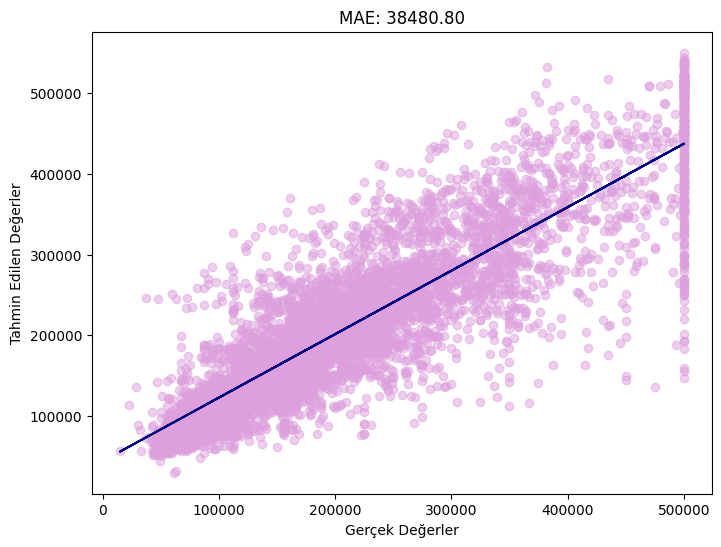

In [248]:
# Gerçek ve tahmin edilen değerler
y_true = prediction.select("median_house_value").toPandas()
y_pred = prediction.select("prediction").toPandas()

# Scatter plot çizimi (MAE)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='plum', alpha=0.5)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('MAE: {:.2f}'.format(float(mae)))  # mae serisinden ilk değeri alıyoruz

# Regresyon eğrisi
z = np.polyfit(y_true['median_house_value'], y_pred['prediction'], 1)
p = np.poly1d(z)
plt.plot(y_true, p(y_true), color='navy')

plt.show()

- r2 değeri 0-1 arasında değer alır ve 1'e yakalştıkça verinin o kadar iyi açıklandığı anlamına gelir. Bu sebeple r2 değerinin 0.75 olması gayetr iyi bir değerdir.

In [249]:
# R-kare (R-squared)
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

# R-kare değeri
r2 = evaluator.evaluate(prediction)

print("R-squared:", r2)


R-squared: 0.7677065485624825


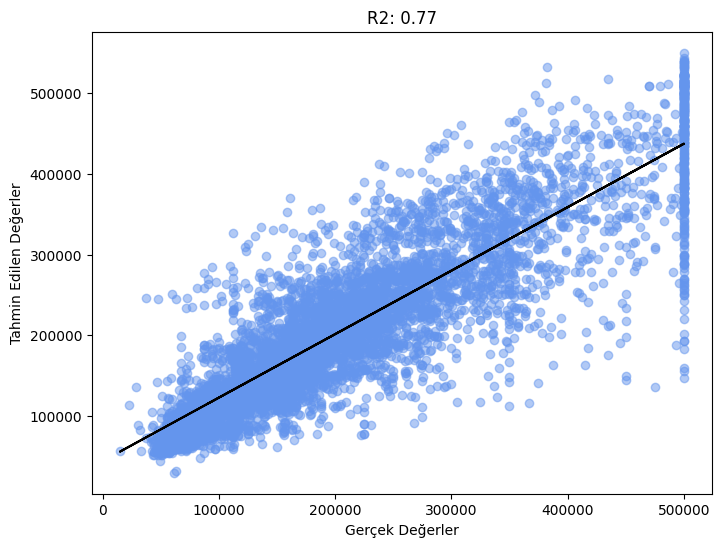

In [250]:
# Scatter plot çizimi (R2)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='cornflowerblue', alpha=0.5)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('R2: {:.2f}'.format(r2))

# Regresyon eğrisi
z = np.polyfit(y_true['median_house_value'], y_pred['prediction'], 1)
p = np.poly1d(z)
plt.plot(y_true, p(y_true), color='black')

plt.show()

## Denenen Diğer Modeller ve R2 Değerleri

In [251]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# LinearRegression modeli
lr = LinearRegression(featuresCol='features', labelCol='median_house_value')

# Modelin eğitimi
lr_model = lr.fit(train_df)

# Test verisi üzerinde tahmin
prediction_lr = lr_model.transform(test_df)

# R-kare (R-squared)
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

# R-kare değeri
r2 = evaluator.evaluate(prediction_lr)

print("R-squared:", r2)


R-squared: 0.6326029100414418


In [252]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

# Random forest regresyon modelini oluşturun
rf = RandomForestRegressor(featuresCol="features", labelCol="median_house_value")

# Modeli eğitin
model = rf.fit(train_df)

# Test verisi üzerinde tahmin yapın
prediction_rf = model.transform(test_df)

# R-kare (R-squared)
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

# R-kare değeri
r2 = evaluator.evaluate(prediction_rf)

print("R-squared:", r2)

R-squared: 0.685832381154709


In [253]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# DecisionTreeRegressor modelini tanımla
dt = DecisionTreeRegressor(featuresCol='scaled_features', labelCol='median_house_value')

# Modeli eğit
dt_model = dt.fit(train_df)

# Test verisi üzerinde tahmin yap
prediction_dt = dt_model.transform(test_df)

# R-kare (R-squared)
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

# R-kare değeri
r2 = evaluator.evaluate(prediction_dt)

print("R-squared:", r2)

R-squared: 0.6551666770921587


Modellerin başarı sıralamaları
- Gradient Boosted Trees Regresyonu
- Random Forest Regresyonu
- Decision Tree Regresyonu
- Lineer Regresyon